# Random UnderSampling 
With and Without replacement

In [1]:
from typing import (List, Union)
from tqdm import tqdm
import yaml
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns
from sklearn.model_selection import (RepeatedStratifiedKFold, cross_validate)
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
import xgboost as xgb
from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from src.utils import print_training_results

In [2]:
# Plot configs:
sns.set_context("paper", font_scale= 1.8)
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plotsize = (22, 5)
plt.rcParams['figure.figsize'] = plotsize
#  Pandas config
pd.options.display.float_format = '{:,.4f}'.format
pd.options.display.max_columns = 200

In [3]:
# Functions
def process_pca_df(df: pd.DataFrame, y: pd.DataFrame, SEED: int) -> Union[pd.DataFrame, np.array]:
    """
    df: X only with numeric features
    y: hit information
    """
    features_remove= ["is_antisense", "locus_is_amplified", "near_cancer_associated_snp",
                    "near_fantom_enhancer", "near_hnisz_enhancer", "near_hnisz_super_enhancer", 
                    "within_ctcf_loop", "within_pol2_loop", "has_mouse_ortholog", "is_intergenic", 
                    "locus_is_heterozygous_deleted"]
    pca_df = df.drop(columns= features_remove)
    # PCA
    scaled_data = scale(pca_df)
    pca = PCA(random_state= SEED).fit(scaled_data)
    pca_data = pca.transform(scaled_data)
    per_var = np.round( pca.explained_variance_ratio_ * 100, 4 )
    labels = ["PC" + str(i) for i in range(1, len(per_var) + 1)]
    pca_plot = pd.DataFrame(pca_data, columns= labels, index= pca_df.index)
    pca_plot["hit"]= y["hit"].astype(int)    
    return pca_plot, per_var

## 1) Input Data
The input data can be found, and download here: [zenodo link](https://zenodo.org/records/10251230)

In [4]:
df = pd.read_csv("../data/data_143_features.csv")
print(df.shape)
df.head()

(50847, 144)


,log2_fpkm,near_fantom_enhancer,near_cancer_associated_snp,number_of_exons,within_pol2_loop,near_hnisz_super_enhancer,within_ctcf_loop,near_hnisz_enhancer,has_mouse_ortholog,locus_is_heterozygous_deleted,is_intergenic,transcript_length,locus_is_amplified,is_antisense,locus_locus_distance,tss_pc_distance,near_vista_enhancer,locus_is_homozygous_deleted,ARID3A,ATF1,ATF2,ATF3,BACH1,BCLAF1,BHLHE40,BRCA1,CBX3,CBX8,CEBPB,CEBPZ,CHD1,CHD2,CHD7,CREB1,CTBP2,CTCF,CTCFL,CUX1,E2F1,E2F4,E2F6,EGR1,ELF1,ELK1,EP300,ESRRA,ETS1,EZH2,FOS,FOSL1,FOSL2,FOXA1,FOXM1,GABPA,GATA1,GATA2,GATA3,GTF2F1,HCFC1,HDAC1,HDAC2,HDAC6,HSF1,IKZF1,IRF1,JUN,JUND,KDM1A,KDM5A,KDM5B,MAFF,MAFK,MAX,MAZ,MEF2A,MTA3,MXI1,MYBL2,MYC,NANOG,NCOR1,NFE2,NFIC,NFYA,NFYB,NR2C2,NR2F2,NR3C1,NRF1,PHF8,PML,POLR2A,POU5F1,RAD21,RBBP5,RCOR1,RELA,REST,RFX5,RNF2,RXRA,SAP30,SETDB1,SIN3A,SIX5,SMARCA4,SMARCB1,SMARCC2,SMC3,SP1,SPI1,SREBF1,SREBF2,SRF,STAT5A,SUPT20H,SUZ12,TAF1,TAF7,TAL1,TBL1XR1,TBP,TCF12,TCF7L2,TEAD4,THAP1,TRIM28,UBTF,USF1,USF2,YY1,ZBTB33,ZBTB7A,ZC3H11A,ZKSCAN1,ZMIZ1,ZNF143,ZNF217,ZNF263,ZNF274,ZNF384,ZZZ3,number_tfs,hit
0,2.9612,0,0,2.5000,0,0,0,0,0,0,1,"3,019.5000",0,0,43833,48473,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,0
1,-0.1795,0,0,2.0000,0,0,0,0,0,0,1,609.0000,0,0,42685,44966,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,0
2,-1.3535,0,1,2.0000,0,0,0,0,1,0,1,582.0000,0,0,0,22062,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,0
3,-1.0786,0,0,4.0000,0,0,0,0,0,0,1,639.0000,0,0,0,7516,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000

## 2) Train/Test Split

In [5]:
X = df.drop(columns=["hit"]).copy(deep=True)
print(X.shape)
X.head()

(50847, 143)


,log2_fpkm,near_fantom_enhancer,near_cancer_associated_snp,number_of_exons,within_pol2_loop,near_hnisz_super_enhancer,within_ctcf_loop,near_hnisz_enhancer,has_mouse_ortholog,locus_is_heterozygous_deleted,is_intergenic,transcript_length,locus_is_amplified,is_antisense,locus_locus_distance,tss_pc_distance,near_vista_enhancer,locus_is_homozygous_deleted,ARID3A,ATF1,ATF2,ATF3,BACH1,BCLAF1,BHLHE40,BRCA1,CBX3,CBX8,CEBPB,CEBPZ,CHD1,CHD2,CHD7,CREB1,CTBP2,CTCF,CTCFL,CUX1,E2F1,E2F4,E2F6,EGR1,ELF1,ELK1,EP300,ESRRA,ETS1,EZH2,FOS,FOSL1,FOSL2,FOXA1,FOXM1,GABPA,GATA1,GATA2,GATA3,GTF2F1,HCFC1,HDAC1,HDAC2,HDAC6,HSF1,IKZF1,IRF1,JUN,JUND,KDM1A,KDM5A,KDM5B,MAFF,MAFK,MAX,MAZ,MEF2A,MTA3,MXI1,MYBL2,MYC,NANOG,NCOR1,NFE2,NFIC,NFYA,NFYB,NR2C2,NR2F2,NR3C1,NRF1,PHF8,PML,POLR2A,POU5F1,RAD21,RBBP5,RCOR1,RELA,REST,RFX5,RNF2,RXRA,SAP30,SETDB1,SIN3A,SIX5,SMARCA4,SMARCB1,SMARCC2,SMC3,SP1,SPI1,SREBF1,SREBF2,SRF,STAT5A,SUPT20H,SUZ12,TAF1,TAF7,TAL1,TBL1XR1,TBP,TCF12,TCF7L2,TEAD4,THAP1,TRIM28,UBTF,USF1,USF2,YY1,ZBTB33,ZBTB7A,ZC3H11A,ZKSCAN1,ZMIZ1,ZNF143,ZNF217,ZNF263,ZNF274,ZNF384,ZZZ3,number_tfs
0,2.9612,0,0,2.5000,0,0,0,0,0,0,1,"3,019.5000",0,0,43833,48473,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0
1,-0.1795,0,0,2.0000,0,0,0,0,0,0,1,609.0000,0,0,42685,44966,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0
2,-1.3535,0,1,2.0000,0,0,0,0,1,0,1,582.0000,0,0,0,22062,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0
3,-1.0786,0,0,4.0000,0,0,0,0,0,0,1,639.0000,0,0,0,7516,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0

In [6]:
nan_features = X.isna().sum().reset_index().rename(columns={"index": "features", 0: "is_na"})
nan_features[nan_features["is_na"] == 1]

,features,is_na


In [7]:
y = df[['hit']].astype('int64').copy(deep=True)
num_classses = Counter(y.values.ravel())
print(num_classses)
y.head()

Counter({0: 49936, 1: 911})


,hit
0,0
1,0
2,0
3,0
4,0


## 3) XGBoost model

In [8]:
# Model configs
with open("config_files/config_under_sampling.yaml", "r") as file:
    config = yaml.safe_load(file)

# ML configs
SEED = config["SEED"]["seed"]
xgboost_configs = config["xgboost"]

In [9]:
# CV:
stratified_cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state= SEED)

# scoring:
scoring = {"sensitivity": "recall", 
            "auroc": "roc_auc",
            "f1_score": "f1", 
            "precision": "precision",
            }

# XGBoost model
xgboost_model = xgb.XGBClassifier(**xgboost_configs)

## 4) Random Undersampling

### 4.1) Randon Undersampling Without Replacement

In [10]:
%%time

under_sampling_strategies = [0.03, 0.04, 0.05, 0.10, 0.20, 0.30, 0.40, 0.50]

for i in tqdm(under_sampling_strategies):
    print(f"Under Sampling strategy: {i: .0%}")
    random_pipeline = make_pipeline(RandomUnderSampler(sampling_strategy= i, random_state= SEED, replacement= False), xgboost_model)
    cv_result = cross_validate(random_pipeline, 
                                X, 
                                y.values.ravel(), 
                                cv= stratified_cv, 
                                scoring= list(scoring.values()), 
                                return_train_score= False, 
                                verbose=0)
    print_training_results(scoring_dict=scoring, input_model=xgboost_model, cv_results=cv_result)

  0%|          | 0/8 [00:00<?, ?it/s]

Under Sampling strategy:  3%


 12%|█▎        | 1/8 [00:27<03:15, 27.99s/it]

----------
XGBClassifier mean-sensitivity: 0.1627 (+/-  0.04)
XGBClassifier mean-auroc: 0.8250 (+/-  0.02)
XGBClassifier mean-f1_score: 0.2360 (+/-  0.05)
XGBClassifier mean-precision: 0.4363 (+/-  0.09)
----------
Under Sampling strategy:  4%


 25%|██▌       | 2/8 [00:52<02:37, 26.24s/it]

----------
XGBClassifier mean-sensitivity: 0.2001 (+/-  0.05)
XGBClassifier mean-auroc: 0.8270 (+/-  0.02)
XGBClassifier mean-f1_score: 0.2621 (+/-  0.06)
XGBClassifier mean-precision: 0.3868 (+/-  0.08)
----------
Under Sampling strategy:  5%


 38%|███▊      | 3/8 [01:16<02:05, 25.20s/it]

----------
XGBClassifier mean-sensitivity: 0.2341 (+/-  0.05)
XGBClassifier mean-auroc: 0.8281 (+/-  0.02)
XGBClassifier mean-f1_score: 0.2818 (+/-  0.06)
XGBClassifier mean-precision: 0.3583 (+/-  0.06)
----------
Under Sampling strategy:  10%


 50%|█████     | 4/8 [01:37<01:33, 23.37s/it]

----------
XGBClassifier mean-sensitivity: 0.3556 (+/-  0.06)
XGBClassifier mean-auroc: 0.8270 (+/-  0.02)
XGBClassifier mean-f1_score: 0.3073 (+/-  0.04)
XGBClassifier mean-precision: 0.2716 (+/-  0.04)
----------
Under Sampling strategy:  20%


 62%|██████▎   | 5/8 [01:56<01:05, 21.80s/it]

----------
XGBClassifier mean-sensitivity: 0.4946 (+/-  0.05)
XGBClassifier mean-auroc: 0.8292 (+/-  0.02)
XGBClassifier mean-f1_score: 0.2633 (+/-  0.02)
XGBClassifier mean-precision: 0.1797 (+/-  0.01)
----------
Under Sampling strategy:  30%


 75%|███████▌  | 6/8 [02:13<00:40, 20.26s/it]

----------
XGBClassifier mean-sensitivity: 0.5638 (+/-  0.05)
XGBClassifier mean-auroc: 0.8302 (+/-  0.02)
XGBClassifier mean-f1_score: 0.2182 (+/-  0.02)
XGBClassifier mean-precision: 0.1354 (+/-  0.01)
----------
Under Sampling strategy:  40%


 88%|████████▊ | 7/8 [02:30<00:19, 19.08s/it]

----------
XGBClassifier mean-sensitivity: 0.6114 (+/-  0.04)
XGBClassifier mean-auroc: 0.8289 (+/-  0.02)
XGBClassifier mean-f1_score: 0.1888 (+/-  0.01)
XGBClassifier mean-precision: 0.1117 (+/-  0.01)
----------
Under Sampling strategy:  50%


100%|██████████| 8/8 [02:46<00:00, 20.83s/it]

----------
XGBClassifier mean-sensitivity: 0.6458 (+/-  0.04)
XGBClassifier mean-auroc: 0.8269 (+/-  0.02)
XGBClassifier mean-f1_score: 0.1679 (+/-  0.01)
XGBClassifier mean-precision: 0.0966 (+/-  0.01)
----------
CPU times: user 4min 33s, sys: 3.29 s, total: 4min 37s
Wall time: 2min 46s


### 4.2) Randon Undersampling With Replacement

In [11]:
%%time

under_sampling_strategies = [0.03, 0.04, 0.05, 0.10, 0.20, 0.30, 0.40, 0.50]

for i in tqdm(under_sampling_strategies):
    print(f"Under Sampling strategy: {i: .0%}")
    random_pipeline = make_pipeline(RandomUnderSampler(sampling_strategy= i, random_state= SEED, replacement= True), xgboost_model)
    cv_result = cross_validate(random_pipeline, 
                                X, 
                                y.values.ravel(), 
                                cv= stratified_cv, 
                                scoring= list(scoring.values()), 
                                return_train_score= False, 
                                verbose=0)
    print_training_results(scoring_dict=scoring, input_model=xgboost_model, cv_results=cv_result)

  0%|          | 0/8 [00:00<?, ?it/s]

Under Sampling strategy:  3%


 12%|█▎        | 1/8 [00:28<03:17, 28.15s/it]

----------
XGBClassifier mean-sensitivity: 0.1895 (+/-  0.05)
XGBClassifier mean-auroc: 0.8238 (+/-  0.02)
XGBClassifier mean-f1_score: 0.2531 (+/-  0.06)
XGBClassifier mean-precision: 0.3858 (+/-  0.08)
----------
Under Sampling strategy:  4%


 25%|██▌       | 2/8 [00:53<02:40, 26.69s/it]

----------
XGBClassifier mean-sensitivity: 0.2301 (+/-  0.06)
XGBClassifier mean-auroc: 0.8257 (+/-  0.02)
XGBClassifier mean-f1_score: 0.2815 (+/-  0.06)
XGBClassifier mean-precision: 0.3665 (+/-  0.07)
----------
Under Sampling strategy:  5%


 38%|███▊      | 3/8 [01:18<02:07, 25.58s/it]

----------
XGBClassifier mean-sensitivity: 0.2594 (+/-  0.05)
XGBClassifier mean-auroc: 0.8258 (+/-  0.02)
XGBClassifier mean-f1_score: 0.2918 (+/-  0.05)
XGBClassifier mean-precision: 0.3356 (+/-  0.06)
----------
Under Sampling strategy:  10%


 50%|█████     | 4/8 [01:39<01:35, 23.80s/it]

----------
XGBClassifier mean-sensitivity: 0.3604 (+/-  0.04)
XGBClassifier mean-auroc: 0.8307 (+/-  0.02)
XGBClassifier mean-f1_score: 0.2980 (+/-  0.04)
XGBClassifier mean-precision: 0.2546 (+/-  0.03)
----------
Under Sampling strategy:  20%


 62%|██████▎   | 5/8 [01:58<01:06, 22.27s/it]

----------
XGBClassifier mean-sensitivity: 0.4873 (+/-  0.05)
XGBClassifier mean-auroc: 0.8316 (+/-  0.02)
XGBClassifier mean-f1_score: 0.2609 (+/-  0.02)
XGBClassifier mean-precision: 0.1784 (+/-  0.02)
----------
Under Sampling strategy:  30%


 75%|███████▌  | 6/8 [02:16<00:41, 20.85s/it]

----------
XGBClassifier mean-sensitivity: 0.5675 (+/-  0.05)
XGBClassifier mean-auroc: 0.8301 (+/-  0.02)
XGBClassifier mean-f1_score: 0.2183 (+/-  0.02)
XGBClassifier mean-precision: 0.1353 (+/-  0.01)
----------
Under Sampling strategy:  40%


 88%|████████▊ | 7/8 [02:34<00:19, 19.68s/it]

----------
XGBClassifier mean-sensitivity: 0.6172 (+/-  0.05)
XGBClassifier mean-auroc: 0.8306 (+/-  0.02)
XGBClassifier mean-f1_score: 0.1915 (+/-  0.01)
XGBClassifier mean-precision: 0.1134 (+/-  0.01)
----------
Under Sampling strategy:  50%


100%|██████████| 8/8 [02:50<00:00, 21.34s/it]

----------
XGBClassifier mean-sensitivity: 0.6312 (+/-  0.05)
XGBClassifier mean-auroc: 0.8253 (+/-  0.02)
XGBClassifier mean-f1_score: 0.1646 (+/-  0.01)
XGBClassifier mean-precision: 0.0947 (+/-  0.01)
----------
CPU times: user 4min 41s, sys: 3.23 s, total: 4min 44s
Wall time: 2min 50s


## 5) EDA of replacement strategies

In [12]:
data = pd.read_csv("../data/data.71.features.csv")
data.head()

,Cell,Gene,Is antisense,Locus is amplified,Locus locus distance,Log2 FPKM,Near cancer associated SNP,Near fantom enhancer,Near hnisz enhancer,Near hnisz super enhancer,Number of exons,TSS PC distance,Transcript length,Within CTCF loop,Within Pol2 loop,Has mouse ortholog,Is intergenic,Locus is heterozygous deleted,ATF1,ATF2,CBX3,CEBPB,CHD2,CREB1,CTCF,E2F1,E2F6,EGR1,ELF1,EP300,ESRRA,FOS,FOSL1,FOXM1,GABPA,GTF2F1,HCFC1,HDAC1,IKZF1,IRF1,JUND,KDM5B,MAFF,MAFK,MAZ,MTA3,MYC,NCOR1,NFIC,NR2C2,Number of TFs,PHF8,POLR2A,RAD21,RBBP5,REST,RNF2,SAP30,SIN3A,SMARCA4,SP1,SPI1,SREBF2,TAF1,TAF7,TBP,TEAD4,THAP1,UBTF,YY1,ZBTB33,ZBTB7A,ZNF384,Hit
0,K562,LH00001,0,0,43833,2.9612,0,0,0,0,2.5000,48473,"3,019.5000",0,0,0,1,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,K562,LH00002,0,0,42685,-0.1795,0,0,0,0,2.0000,44966,609.0000,0,0,0,1,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,K562,LH00004,0,0,0,-1.3535,1,0,0,0,2.0000,22062,582.0000,0,0,1,1,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3,K562,LH00005,0,0,0,-1.0786,0,0,0,0,4.0000,7516,639.0000,0,0,0,1,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
4,K562,LH00006,0,0,92687,-3.3219,0,0,0,0,2.0000,93681,295.0000,0,0,0,1,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


In [13]:
# We are going to drop metadata, categorical features, and target column (hit)
pca_columns_to_drop = ["Cell", "Gene", "Is antisense", "Locus is amplified", "Near cancer associated SNP",
                        "Near fantom enhancer", "Near hnisz enhancer", "Near hnisz super enhancer", 
                        "Within CTCF loop", "Within Pol2 loop", "Has mouse ortholog", "Is intergenic", 
                        "Locus is heterozygous deleted", "Hit"]

pca_df = data.drop(columns= pca_columns_to_drop).copy(deep=True)
print(pca_df.shape)
pca_df.head()

(50847, 60)


,Locus locus distance,Log2 FPKM,Number of exons,TSS PC distance,Transcript length,ATF1,ATF2,CBX3,CEBPB,CHD2,CREB1,CTCF,E2F1,E2F6,EGR1,ELF1,EP300,ESRRA,FOS,FOSL1,FOXM1,GABPA,GTF2F1,HCFC1,HDAC1,IKZF1,IRF1,JUND,KDM5B,MAFF,MAFK,MAZ,MTA3,MYC,NCOR1,NFIC,NR2C2,Number of TFs,PHF8,POLR2A,RAD21,RBBP5,REST,RNF2,SAP30,SIN3A,SMARCA4,SP1,SPI1,SREBF2,TAF1,TAF7,TBP,TEAD4,THAP1,UBTF,YY1,ZBTB33,ZBTB7A,ZNF384
0,43833,2.9612,2.5000,48473,"3,019.5000",0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,42685,-0.1795,2.0000,44966,609.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,0,-1.3535,2.0000,22062,582.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3,0,-1.0786,4.0000,7516,639.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
4,92687,-3.3219,2.0000,93681,295.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


In [14]:
# Scale the input data and do the dimensionality reduction
scaled_data = scale(pca_df)
pca = PCA(random_state=SEED).fit(scaled_data)
pca_data = pca.transform(scaled_data)

per_var = np.round(pca.explained_variance_ratio_ * 100, 4)
labels = ["PC" + str(i) for i in range(1, len(per_var) + 1)]

pca_plot = pd.DataFrame(pca_data, columns= labels, index= pca_df.index)
pca_plot["hit"]= data["Hit"].astype(int)
print(f"PCA df shape: {pca_plot.shape}")

pca_plot.head()

PCA df shape: (50847, 61)


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50,PC51,PC52,PC53,PC54,PC55,PC56,PC57,PC58,PC59,PC60,hit
0,-0.9073,-0.0079,0.0019,0.0585,0.1093,-0.0808,0.2226,0.0827,-0.0355,-0.3027,-0.3967,-0.1481,0.1828,0.4261,-0.0859,0.2222,-0.0152,-0.1786,-0.2954,-0.2692,0.4704,-0.4947,0.2848,-0.2002,-0.7969,0.0354,-0.1751,-0.3052,0.0539,0.0190,0.0458,0.1145,0.1417,0.1445,-0.0109,0.0271,0.0633,0.0365,0.0456,0.0160,-0.0223,-0.0957,-0.0356,0.0412,0.0205,0.0477,0.0623,-0.0472,0.0131,-0.0583,-0.0235,0.0216,-0.0094,0.0090,-0.0035,0.0105,-0.0026,-0.0120,-0.1296,0.0610,0
1,-0.9239,0.0931,-0.1466,-0.0264,0.0381,0.1042,0.0524,0.0825,-0.0370,-0.0203,-0.4336,0.0708,-0.1525,-0.0358,0.1223,0.0755,-0.0476,0.0738,0.1024,0.0090,-0.0165,-0.0519,-0.1019,-0.0030,0.1922,0.0136,0.0500,0.0907,-0.0023,-0.0028,0.0000,-0.0021,0.0046,-0.0336,0.0349,-0.0026,-0.0367,0.0216,0.0164,0.0249,-0.0073,0.0004,-0.0118,0.0124,0.0370,0.0084,0.0148,-0.0127,-0.0060,-0.0114,-0.0085,0.0031,-0.0009,0.0074,0.0097,0.0107,0.0129,-0.0126,-0.1405,0.0507,0
2,-0.9261,0.1122,-0.1904,-0.1503,0.2492,0.2551,-0.0134,0.0936,-0.0296,0.1035,-0.1922,0.1194,-0.1850,-0.1900,0.1234,0.0192,-0.0334,0.1178,0.1897,0.0831,-0.1389,0.1282,-0.2093,0.0690,0.5037,-0.0002,0.1246,0.2204,-0.0236,-0.0013,-0.0134,-0.0418,-0.0402,-0.0953,0.0538,-0.0088,-0.0714,0.0189,0.0060,0.0302,0.0036,0.0330,-0.0080,0.0054,0.0421,-0.0053,-0.0002,-0.0011,-0.0136,0.0027,-0.0060,-0.0006,0.0036,0.0081,0.0153,0.0111,0.0168,-0.0098,-0.0097,0.0443,0
3,-0.8966,0.0780,-0.1502,-0.0826,0.1763,0.1775,-0.0022,0.0275,0.0054,0.0198,0.3611,-0.0862,0.1773,0.2855,-0.0665,0.1903,-0.0103,0.1198,-0.0887,-0.2062,0.3162,-0.4392,-0.5092,0.0461,0.9046,-0.1738,0.1978,0.2768,-0.0590,0.0538,-0.0343,-0.0087,-0.0015,-0.0911,0.0841,0.0191,-0.0842,0.0393,0.0347,0.0276,0.0026,0.0092,-0.0490,0.0285,0.0444,0.0126,0.0147,-0.0211,-0.0164,-0.0187,-0.0246,0.0108,-0.0013,0.0065,0.0145,0.0121,0.0205,-0.0181,-0.0600,0.0629,0
4,-0.9473,0.2296,-0.3245,0.0806,-0.4805,0.1491,-0.1277,0.0521,-0.0281,0.2646,0.0296,0.2387,-0.2700,-0.4742,0.1460,-0.0866,-0.0128,0.1985,0.3608,0.2427,-0.4356,0.4059,-0.3955,0.1851,0.9833,-0.0159,0.2451,0.4149,-0.0526,-0.0141,-0.0438,-0.1092,-0.1190,-0.1910,0.0709,-0.0268,-0.1245,0.0034,-0.0186,0.0255,0.0139,0.0849,0.0052,-0.0103,0.0438,-0.0235,-0.0338,0.0155,-0.0238,0.0354,0.0058,-0.0133,0.0131,0.0043,0.0226,0.0067,0.0259,-0.0173,-0.2333,0.0423,0


### 5.1) EDA of the Random Undersampling strategy

In [15]:
# Create a list of Random Undersamplers 
under_sampling_strategies = [0.03, 0.04, 0.05, 0.10, 0.20, 0.30, 0.40, 0.50]
samplers = []
for i in under_sampling_strategies:
    init_sampler = RandomUnderSampler(sampling_strategy= i, random_state= SEED, replacement= False)
    samplers.append(init_sampler)

# Plot vars
counter = Counter(pca_plot['hit'])
ALPHA = 0.7
POINT_SIZE = 12
NOT_HIT_COLOR = "grey"
HIT_COLOR = "red"

8it [00:01,  4.89it/s]


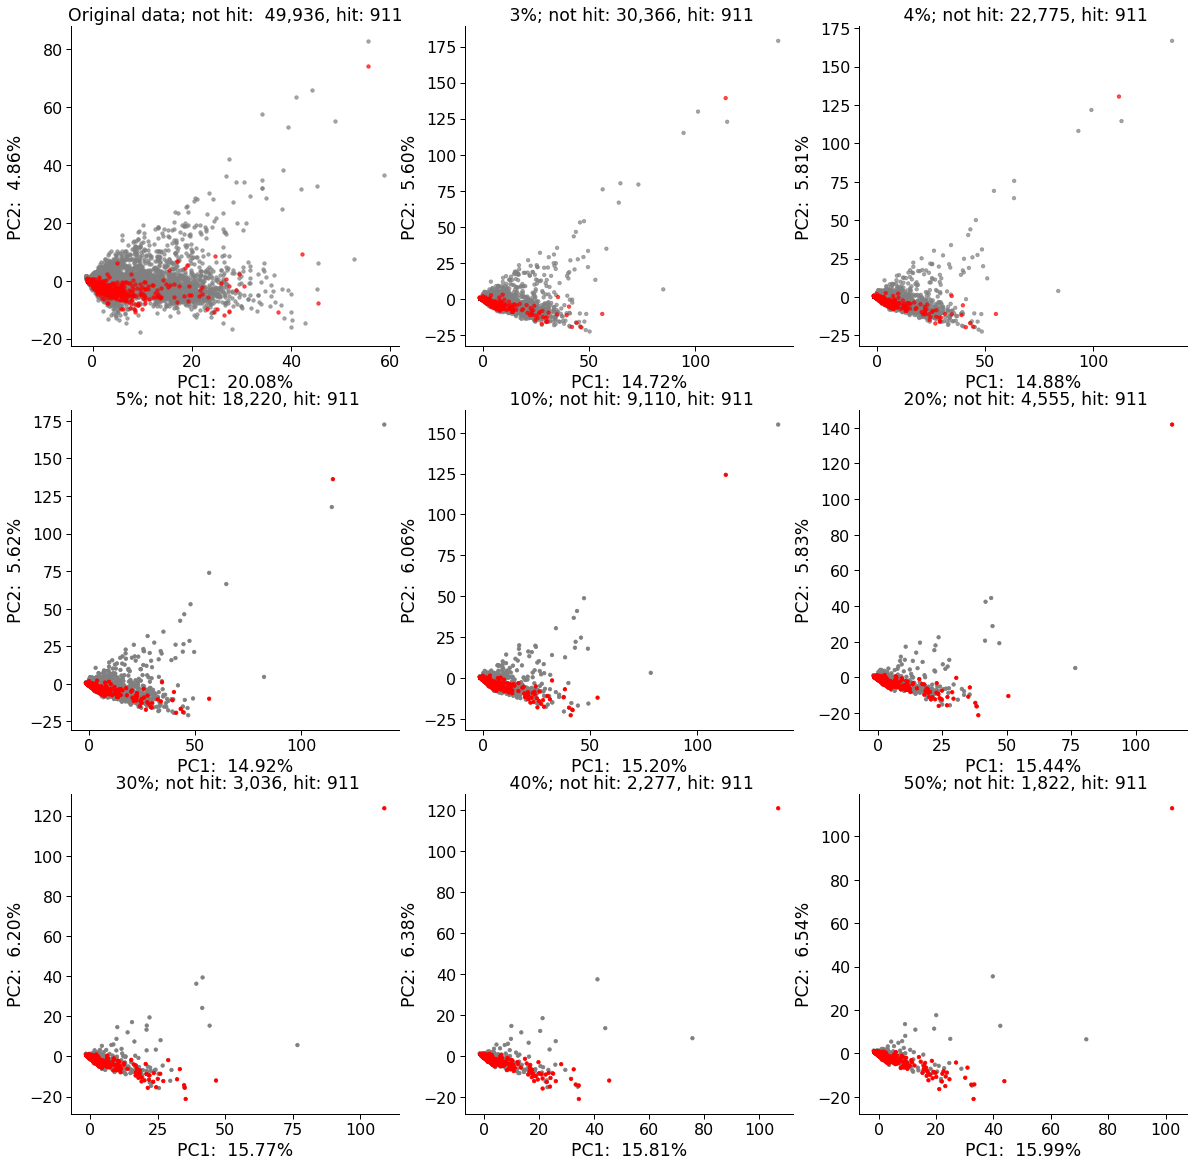

In [16]:
# Scatter PCA plots
fig, ax= plt.subplots(3,3, figsize= (20, 20))

# Original data
for label, _ in counter.items():
    row_ix = np.where(pca_plot["hit"] == label)[0]
    if label == 0:
        ax[0,0].scatter(pca_plot.iloc[row_ix, 0], pca_plot.iloc[row_ix, 1], 
                        label=str(label), s=POINT_SIZE, c=NOT_HIT_COLOR, alpha=ALPHA, rasterized=True)
    else: 
        ax[0,0].scatter(pca_plot.iloc[row_ix, 0], pca_plot.iloc[row_ix, 1], 
                        label=str(label), s=12, c=HIT_COLOR, alpha=ALPHA, rasterized=True)
ax[0,0].set_title(f"Original data; not hit: { Counter(y.values.ravel())[0]: ,.0f}, hit: { Counter(y.values.ravel())[1] }")
ax[0,0].set_xlabel(f"PC1: {per_var[0]: .2f}%")
ax[0,0].set_ylabel(f"PC2: {per_var[1]: .2f}%")

# Random Unsampling 
new_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", [NOT_HIT_COLOR, HIT_COLOR])
for i,j in tqdm(enumerate(samplers)):
    new_X, new_y = j.fit_resample(X, y)
    pca_under, under_var = process_pca_df(new_X, new_y, SEED= SEED)
    if i < 2:
        row_idx = i+1 
        ax[0, row_idx].scatter(pca_under.iloc[:, 0], pca_under.iloc[:, 1], c=new_y.values, s=POINT_SIZE, cmap=new_cmap, alpha=ALPHA, rasterized=True)
        ax[0, row_idx].set_title(f"{under_sampling_strategies[i]: .0%}; not hit: {Counter(new_y.values.ravel())[0]:,.0f}, hit: {Counter(new_y.values.ravel())[1]}")
        ax[0, row_idx].set_xlabel(f"PC1: {under_var[0]: .2f}%")
        ax[0, row_idx].set_ylabel(f"PC2: {under_var[1]: .2f}%")
    elif i < 5 and i >= 2:
        row_idx = i-2
        ax[1, row_idx].scatter(pca_under.iloc[:, 0], pca_under.iloc[:, 1], c= new_y.values, s= POINT_SIZE, cmap= new_cmap,rasterized= True)
        ax[1, row_idx].set_title(f"{under_sampling_strategies[i]: .0%}; not hit: {Counter(new_y.values.ravel())[0]:,.0f}, hit: {Counter(new_y.values.ravel())[1]}")
        ax[1, row_idx].set_xlabel(f"PC1: {under_var[0]: .2f}%")
        ax[1, row_idx].set_ylabel(f"PC2: {under_var[1]: .2f}%")
    else:
        row_idx = i-5
        ax[2, row_idx].scatter(pca_under.iloc[:, 0], pca_under.iloc[:, 1], c= new_y.values, s= 12, cmap= new_cmap, rasterized= True)
        ax[2, row_idx].set_title(f"{under_sampling_strategies[i]: .0%}; not hit: {Counter(new_y.values.ravel())[0]:,.0f}, hit: {Counter(new_y.values.ravel())[1]}")
        ax[2, row_idx].set_xlabel(f"PC1: {under_var[0]: .2f}%")
        ax[2, row_idx].set_ylabel(f"PC2: {under_var[1]: .2f}%")

plt.show()